In [4]:
# Download the dataset from kaggle (if needed)
import os 
need_download: bool = not os.path.exists("adult-census-income/adult.csv")

if need_download:
    !kaggle datasets download uciml/adult-census-income
    !unzip adult-census-income.zip -d adult-census-income

# Import needed libraries
import pandas as pd
import sklearn.model_selection

In [80]:
# Import the data into a pandas frame
raw_df = pd.read_csv("adult-census-income/adult.csv")

# Process by 
# 1. replacing "?" with Na
# 2. replacing certain columns as category types
processed_df = raw_df.copy()
processed_df.replace("?", pd.NA, inplace=True)


# print(processed_df.dtypes)

# Filter out incomplete rows
complete_df = processed_df.dropna()
print(f"# complete entries = {len(complete_df)}, # incomplete entries = {len(raw_df) - len(complete_df)}")

# complete entries = 30162, # incomplete entries = 2399


In [83]:
# Take a smaller sample among the complete dataframe
# DROP the weights from each row: sample from the population
sample_size: int = 10000
sample_df: pd.DataFrame = complete_df.drop("fnlwgt", axis=1).sample(n = sample_size, replace = True, weights = complete_df["fnlwgt"], random_state = 0)

In [84]:
# Test-train split, 30-70
# This doesn't incorporate weights, though the sample already did this so it doesn't matter
train_df, test_df = sklearn.model_selection.train_test_split(sample_df, test_size = 0.3)

In [85]:
# Export train_df, test_df
train_df.to_csv("input-data/train_df_n=7000_v1.csv")
test_df.to_csv("input-data/test_df_n=3000_v1.csv")

In [ ]:
def get_X_y (df):
    return (df.drop("income", axis = 1), df["income"])

print(f"train dataset contains {train_y.value_counts()["<=50K"]} examples of '<=50K' out of {len(train_y)} examples in total ({train_y.value_counts()["<=50K"] / len(train_y)})")
print(f"test dataset contains {test_y.value_counts()["<=50K"]} examples of '<=50K' out of {len(test_y)} examples in total ({test_y.value_counts()["<=50K"] / len(test_y)})")

In [66]:
# Create a gradient boosting (with histograms, since faster AND can natively handle categorical data)
from sklearn.ensemble import HistGradientBoostingClassifier

num_iterations = 10000

clf = HistGradientBoostingClassifier(loss = 'log_loss',
                                     categorical_features = 'from_dtype', 
                                     learning_rate = 0.1,
                                     max_iter = num_iterations,
                                     max_depth = 1,  # stumps
                                     early_stopping = False
                                     )

In [67]:
clf.fit(train_X, train_y)

HistGradientBoostingClassifier(categorical_features='from_dtype',
                               early_stopping=False, max_depth=1,
                               max_iter=10000)

In [69]:
print(f"Train accuracy = {clf.score(train_X, train_y)}")
print(f"Test accuracy = {clf.score(test_X, test_y)}")

Train accuracy = 0.8771428571428571
Test accuracy = 0.8643333333333333


In [70]:
import numpy as np
import sklearn.metrics

# log-loss
train_loss: np.array = np.zeros(clf.n_iter_)
test_loss: np.array = np.zeros(clf.n_iter_)

# Prediction power with each iteration
staged_train_predict_probas = clf.staged_predict_proba(train_X)
staged_test_predict_probas = clf.staged_predict_proba(test_X)

for (iteration, staged_train_predict_proba) in enumerate(staged_train_predict_probas):
    train_loss[iteration] = sklearn.metrics.log_loss(train_y, staged_train_predict_proba)

for (iteration, staged_test_predict_proba) in enumerate(staged_test_predict_probas):
    test_loss[iteration] = sklearn.metrics.log_loss(test_y, staged_test_predict_proba)

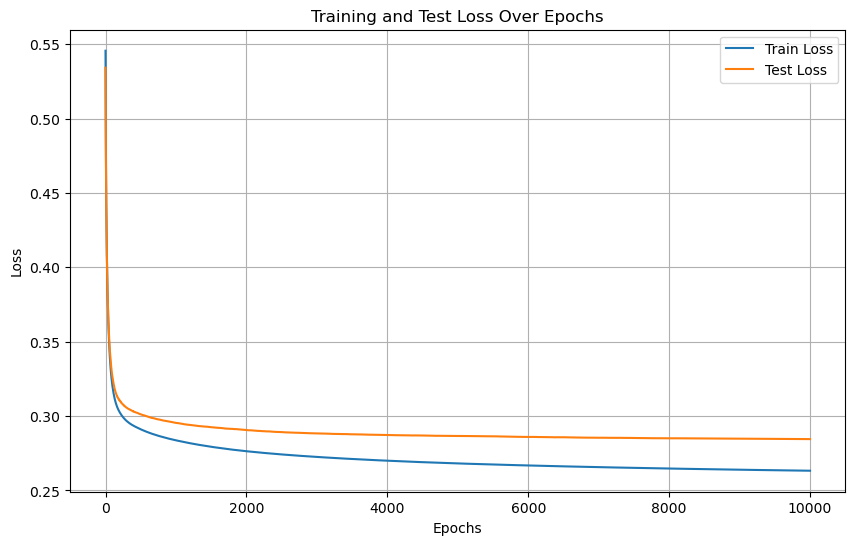

In [71]:
import matplotlib.pyplot as plt

# Example data
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()  # Show legend
plt.grid(True)  # Optional: add a grid

# Show the plot
plt.show()